# Introduction

La pratique de l'aviron en milieu naturel, comme sur les fleuves et rivières, dépend fortement des conditions hydrologiques telles que le débit et la hauteur d'eau. Ces paramètres jouent un rôle crucial dans la sécurité des rameurs, la qualité de l'expérience sportive, et l'organisation des entraînements et compétitions. Toutefois, les variations du débit et de la hauteur d'eau, souvent influencées par les conditions météorologiques (pluies, sécheresses) et les régulations humaines (barrages), rendent leur prévision essentielle pour les clubs d'aviron et les pratiquants. Ce projet vise donc à développer un modèle de prédiction fondé sur des données hydrométriques et météorologiques, permettant d'anticiper les conditions optimales pour la pratique de l'aviron ou à l'inverse de détecter ses potentiels dangers. En combinant l'analyse de données historiques, allant du 01/01/23 à aujourd'hui, avec des approches de modélisation, ce travail a pour objectif de fournir un outil fiable et pratique pour faciliter la planification et garantir la sécurité de la pratique sportive.

Ce projet comprend 3 grandes parties : une partie qui vise à télécharger les bases de données utiles, une partie qui vise à étudier ses bases de données et à les analyser, et une partie qui vise à modéliser le problème pour tenter d'y apporter une réponse satisfiasante.

In [1]:
import os
import requests

import geopandas as gpd
import pandas as pd

In [2]:
os.chdir("/home/onyxia/work/Projet-de-Python-Leroux-Gisserot") # pour l'emplacement
os.environ["PROJ_LIB"] = "/opt/conda/share/proj" # pour les projections sur carte

# Data loading

Dans cette partie, nous importons de data.gouv.fr :
- des bases de données météo horaire pour chaque département
- une base de données concernant la hauteur d'eau et le débit des cours d'eau
- une base de données permettant de tracer ces cours d'eau sur une carte
- une base de données permettant de localiser les clubs d'aviron

In [3]:
from utils.data_loading import (
    read_csv_from_url, 
    load_department_data,
    load_and_save_all_department_data,
    load_data_from_disk,
    station_au_hasard,
)

In [5]:
'''
load_and_save_all_department_data(
    department_ids=[f"{i:02d}" for i in range(1, 96)],
    save_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"
)
'''

Loading data from internet and saving to disk: 100%|██████████| 95/95 [09:27<00:00,  5.98s/it]


In [4]:
meteo_horaire_departement = load_data_from_disk(
    data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"
)

Loading and concatenating data from disk: 100%|██████████| 95/95 [00:18<00:00,  5.17it/s]


In [5]:
# On trie les lignes par département, puis par station et par date
meteo_horaire_departement = meteo_horaire_departement.sort_values(by=["DEPARTMENT_ID", "NOM_USUEL", "AAAAMMJJHH"])

# On formatte les dates pour les utiliser ultérieurement dans les graphes
meteo_horaire_departement["AAAAMMJJHH"] = pd.to_datetime(meteo_horaire_departement["AAAAMMJJHH"], format="%Y%m%d%H")

# On supprime les colonnes qui sont finalement peu utiles (beaucoup de NaN)
meteo_horaire_departement = meteo_horaire_departement.drop(columns=['DRR1', 'U', 'PSTAT'])

Le dataframe meteo_horaire_departement contient les colonnes suivantes :
- DEPARTMENT_ID : le numéro du département où se trouve la station météo
- NOM_USUEL : le nom de la commune où se trouve la station météo
- LAT et LON : les coordonnées de la station météo
- AAAAMMJJHH : la date exacte, à l'heure près, de la collecte d'information
- RR1 : les précipitations tombées en une heure (en mm)
- T : la température moyenne enregistrée pendant cette heure

---

Importation de la base de données fluviales

In [6]:
# Geojson file's URL
geojson_url = "https://www.data.gouv.fr/fr/datasets/r/f354a037-4a4e-4e7e-804b-01278ab228c5"

# Downloading the file locally
geojson_file = "/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/rivers.geojson"
response = requests.get(geojson_url)
if response.status_code == 200:
    with open(geojson_file, "wb") as file:
        file.write(response.content)
else:
    raise Exception("Impossible de télécharger le fichier GeoJSON")

# Load geojson data with geopandas and remove unvalid geometries
rivers = gpd.read_file(geojson_file)
rivers = rivers[rivers.geometry.notnull()]

---

Création d'une base de données avec les stations météo et leurs coordonnées GPS

In [7]:
stations_meteo = meteo_horaire_departement[["NOM_USUEL", "LAT", "LON"]].drop_duplicates()

---

Création d'une station météo test pour l'analyse de données

In [8]:
random_station = stations_meteo["NOM_USUEL"].sample(n=1, random_state=0).iloc[0]
meteo_random_station = station_au_hasard(random_station, meteo_horaire_departement)

# **Data analysis**

In [9]:
from utils.data_analysis import (
    carte_figures,
    trace_graphique,
)

**1. Représentation graphique des fleuves, des stations météo et hydro, et des clubs d'aviron**

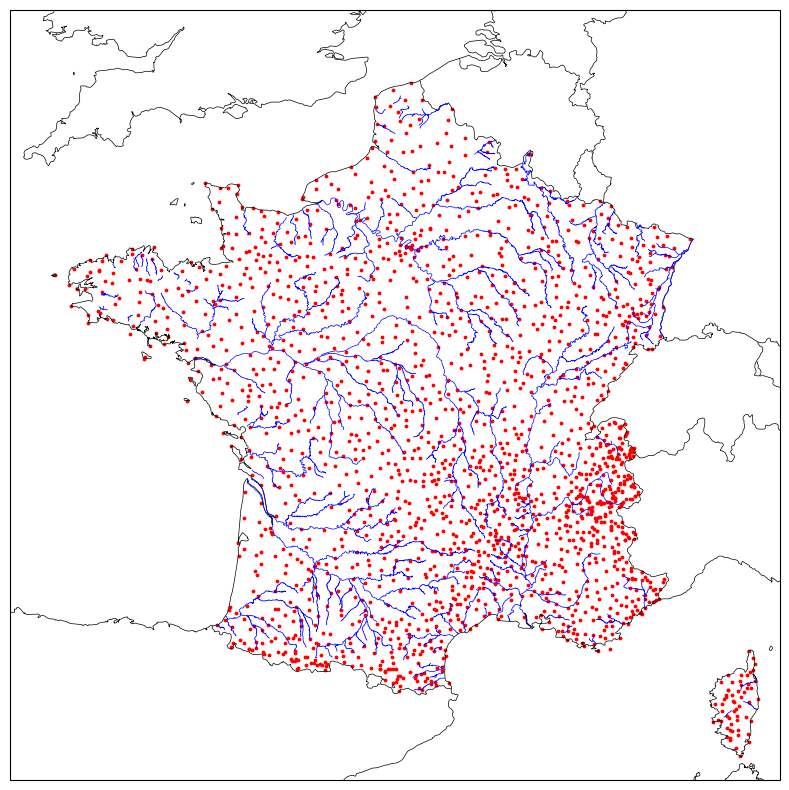

In [10]:
carte_figures(rivers, stations_meteo)

---

**2. Graphe des précipitations en fonction du temps**

2. a. <u>Heure par heure</u>

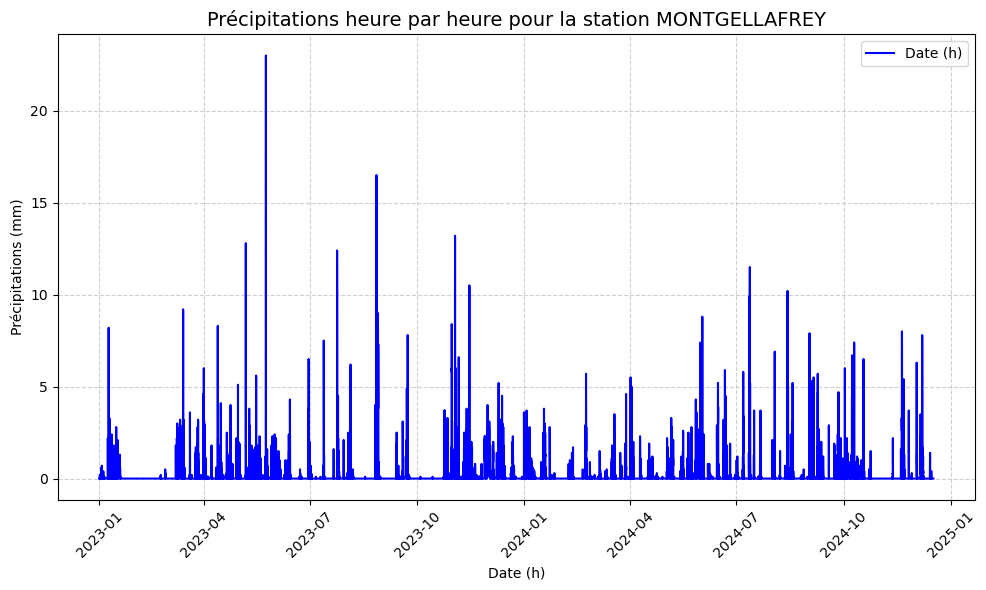

In [12]:
date = meteo_random_station["AAAAMMJJHH"]
precipit = meteo_random_station["RR1"]
titre1 = f"Précipitations heure par heure pour la station {random_station}"
date_label = "Date (h)"
precipit_label = "Précipitations (mm)"

trace_graphique(date, precipit, titre1, date_label, precipit_label)

**Précipitations heure par heure (Graphique 1)** :

Ce graphique détaille les précipitations enregistrées **heure par heure**. Il met en évidence la nature très variable des précipitations, avec de nombreux pics irréguliers.  
- Les pics isolés témoignent de périodes courtes mais **intenses de précipitation**.  
- Entre ces pics, les précipitations sont souvent nulles ou faibles.  

Cette granularité **horaire** est utile pour analyser la variabilité des précipitations à court terme. Toutefois, elle rend difficile la lecture des **tendances globales** à cause de l'apparente "saturation" de l'information.  

Pour un modèle de prévision du débit, ces données brutes heure par heure peuvent donc être **trop détaillées** pour être directement exploitées. En effet, les débits d'un cours d'eau dépendent davantage de cumuls sur des périodes plus longues (journées ou semaines) que d'événements ponctuels.

2. b. <u>Par semaine</u>

In [71]:
# On crée un dataframe où les précipitations sont sommées par semaine
meteo_random_station['hebdo'] = meteo_random_station['AAAAMMJJHH'].dt.to_period('W')
precipit_hebdo = meteo_random_station.groupby('hebdo', as_index=False)['RR1'].sum()
precipit_hebdo['hebdo'] = precipit_hebdo['hebdo'].dt.to_timestamp(how='start')

# Puis on fait une moyenne glissante sur 3 semaines pour lisser la courbe
precipit_hebdo['moy_gliss'] = precipit_hebdo['RR1'].rolling(window=3, min_periods=1, center=True).mean()

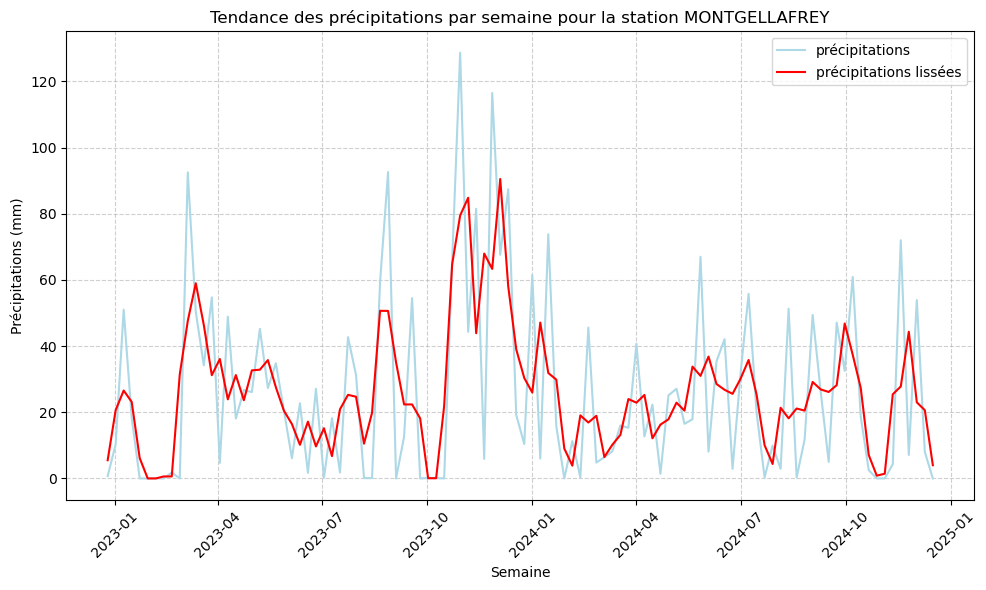

In [74]:
# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(
    precipit_hebdo["hebdo"], precipit_hebdo["RR1"],
    linestyle="-", color="lightblue", label="précipitations"
)
plt.plot(
    precipit_hebdo["hebdo"], precipit_hebdo["moy_gliss"],
    linestyle="-", color="red", label="précipitations lissées"
)

plt.title(f'Tendance des précipitations par semaine pour la station {random_station}')
plt.xlabel('Semaine')
plt.ylabel('Précipitations (mm)')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ce graphique agrège les précipitations à une échelle **hebdomadaire**, ce qui permet de mieux identifier les **tendances globales** dans les précipitations :  
- En bleu clair : la somme hebdomadaire des précipitations montre les fluctuations globales des précipitations au fil du temps.  
- En rouge : la moyenne glissante sur 3 semaines lisse les variations hebdomadaires, révélant les tendances de fond sans être perturbée par des oscillations trop rapides.

Ce lissage est particulièrement utile pour **détecter les périodes humides ou sèches prolongées**, qui influencent directement le débit des cours d'eau. On observe plusieurs pics significatifs sur l'année 2023 (notamment au printemps et en automne), ce qui est cohérent avec les périodes de précipitations accrues.  

Les **sommations hebdomadaires** permettent de mieux **relier les précipitations aux variations de débit**, car elles intègrent une échelle temporelle plus pertinente pour l'évolution du niveau d'eau. La **moyenne glissante** aide à anticiper les périodes où les cours d'eau risquent d'atteindre des niveaux élevés, en réponse à des cumuls prolongés.

---

Pour **prédire le débit d'un cours d'eau**, il serait pertinent d'utiliser les données hebdomadaires comme **variable explicative principale**, en intégrant les tendances de fond issues de la moyenne glissante pour améliorer les prédictions.

---

**3. Graphe des températures en fonction du temps**

3. a. <u>Heure par heure</u>

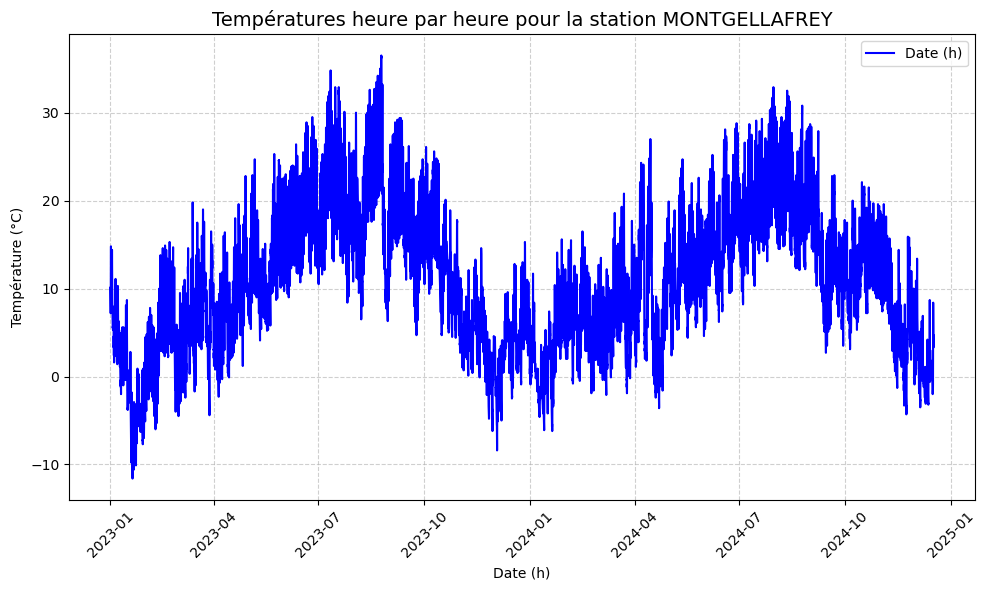

In [13]:
date = meteo_random_station["AAAAMMJJHH"]
temp = meteo_random_station["T"]
titre3 = f"Températures heure par heure pour la station {random_station}"
date_label = "Date (h)"
temp_label = "Température (°C)"

trace_graphique(date, temp, titre3, date_label, temp_label)

3. b. <u>Par semaine</u>

In [78]:
# On reproduit la même méthode que pour les précipitations
temp_hebdo = meteo_random_station.groupby('hebdo', as_index=False)['T'].sum()
temp_hebdo['hebdo'] = temp_hebdo['hebdo'].dt.to_timestamp(how='start')
temp_hebdo['moy_gliss'] = temp_hebdo['T'].rolling(window=3, min_periods=1, center=True).mean()

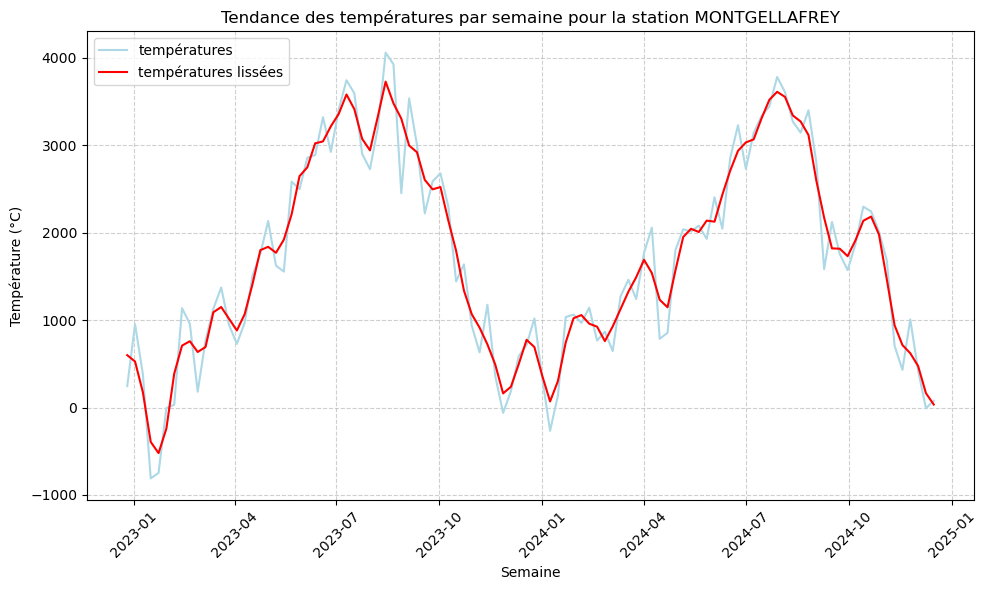

In [80]:
# On trace la température et sa moyenne glissante
plt.figure(figsize=(10, 6))
plt.plot(
    temp_hebdo["hebdo"], temp_hebdo["T"],
    linestyle="-", color="lightblue", label="températures"
)
plt.plot(
    temp_hebdo["hebdo"], temp_hebdo["moy_gliss"],
    linestyle="-", color="red", label="températures lissées"
)

plt.title(f'Tendance des températures par semaine pour la station {random_station}')
plt.xlabel('Semaine')
plt.ylabel('Température (°C)')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Data modeling**